# Process
1. determine the section properties of the cross section
2. find the position with the highest normal stress and place a stringer there
3. rinse and repeat until we've found 7 stringers

In [252]:
import math
import numpy as np
import pandas as pd
from numba import vectorize
import matplotlib.pyplot as plt
import json

# Parameterization

In [253]:
stringer_step = 1 / 4
outside_len = 8

t = np.arange(start=0, stop=outside_len, step=stringer_step)


@vectorize(nopython=True)
def pos_y(t):
    if t < 4:
        return 15 * math.cos(0.066865794705 * t + 1.43706473738) + 2
    else:
        return t - 4


@vectorize(nopython=True)
def pos_z(t):
    if t < 4:
        return 15 * math.sin(0.066865794705 * t + 1.43706473738) - 13.6160687473
    else:
        return (t - 4) / 8


@vectorize(nopython=True)
def thickness(t):
    return 1 / 32


@vectorize(nopython=True)
def mod_elastic(t):
    return 2036e3


points = np.array((pos_y(t), pos_z(t), thickness(t), mod_elastic(t)))

Verify points

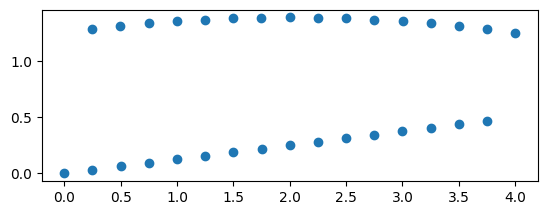

In [254]:
plt.scatter(points[0], points[1])
ax = plt.gca()
ax.set_aspect("equal")

# Stress equations

In [255]:
@vectorize(nopython=True)
def shear_stress(load, y_bar, thickness):
    return (load * (y_bar - 1) + 5 * y_bar - 10) / (4.136 * thickness)


@vectorize(
    nopython=True,
)
def normal_stress(
    load,
    x,
    y,
    z,
    i_yy,
    i_zz,
    i_yz,
    mod_elastic,
):
    return -y * ((load - 5) * (x - 45.75) * i_yz / (i_yy * i_zz - i_yz**2)) + z * (
        (load - 5) * (x - 45.75) * i_zz / (i_yy * i_zz - i_yz**2)
    )

# Section Properties

In [256]:
def section_properties(stringer_positions):
    shape = (4 + stringer_positions.shape[0], stringer_positions.shape[1])
    area = np.zeros(shape)
    y = np.zeros(shape)
    z = np.zeros(shape)
    i_yy = np.zeros(shape)
    i_zz = np.zeros(shape)
    i_yz = np.zeros(shape)
    mod_elastic = np.zeros(shape)

    # Seed 4 parts that are always there
    ## rear spar
    area[0] = 0.09375
    y[0] = 3.9375
    z[0] = 0.875
    i_yy[0] = 0.00439453125
    i_zz[0] = 0.0001220703125  # Izz*
    i_yz[0] = 0.0
    mod_elastic[0] = 1926.0e3  # modulus of elasticity

    ## top skin
    area[1] = 0.12525
    y[1] = 2
    z[1] = 1.354
    i_yy[1] = 0.0007491
    i_zz[1] = 0.16706
    i_yz[1] = 0
    mod_elastic[1] = 2036e3

    ## front spar
    area[2] = 0.15625
    y[2] = 0.0625
    z[2] = 0.625
    i_yy[2] = 0.02034505208
    i_zz[2] = 0.0002034505208
    i_yz[2] = 0
    mod_elastic[2] = 1926e3

    ## bottom skin
    area[3] = 0.12597
    y[3] = 2
    z[3] = 0.23438
    i_yy[3] = 0.00263426
    i_zz[3] = 0.16796
    i_yz[3] = 0.0209929
    mod_elastic[3] = 2036e3

    # Stringer properties
    area[4:] = 0.015625
    i_yy[4:] = 0.0000203451
    i_zz[4:] = 0.0000203451
    mod_elastic[4:] = 2.010e6

    for i in range(stringer_positions.shape[0]):
        y[4 + i] = pos_y(stringer_positions[i])
        z[4 + i] = pos_z(stringer_positions[i])

    y_bar_tot = np.sum(mod_elastic * area * y) / np.sum(mod_elastic * area)
    z_bar_tot = np.sum(mod_elastic * area * z) / np.sum(mod_elastic * area)
    i_yy_tot = np.sum(mod_elastic * (i_yy + area * (z - z_bar_tot) ** 2))
    i_zz_tot = np.sum(mod_elastic * (i_zz + area * (y - y_bar_tot) ** 2))
    i_yz_tot = np.sum(mod_elastic * (i_yz + area * (y - y_bar_tot) * (z - z_bar_tot)))
    return (y_bar_tot, z_bar_tot, i_yy_tot, i_zz_tot, i_yz_tot)

In [262]:
stringers = []
for i in range(7):
    stringer_positions = np.array([[pos, *stringers] for pos in t]).T
    (y_bar, z_bar, i_yy, i_zz, i_yz) = section_properties(stringer_positions)
    norm_stress = normal_stress(
        50, 0, points[0], points[1], i_yy, i_zz, i_yz, points[3]
    )
    sorted_indices = np.flip(np.argsort(abs(norm_stress)))
    loc = -1
    for i in sorted_indices:
        if stringer_positions[0, i] not in stringers:
            stringers = stringer_positions[:, i]
            break


print(json.dumps(stringers.tolist()))

[3.5, 2.0, 2.25, 3.25, 2.5, 2.75, 3.0]
